# Štatistiky

Načítanie modulov

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

Načítanie dát

In [2]:
games_df = pd.read_json("data/games.json")

In [3]:
runs_df = None
for id, row in games_df.iterrows():
    try:
        run_df = pd.read_json("data/runs/{}.json".format(row["id"]))
    except Exception:
        print("Error opening file for {}".format(row["id"]))
        continue
    if run_df.empty or not (((run_df["game"] == row["name"]) & (run_df["region"] == "JPN / NTSC")).any() and ((run_df["game"] == row["name"]) & (run_df["region"] != "JPN / NTSC")).any()):
        continue
    if runs_df is None:
        runs_df = run_df
    else:
        runs_df = pd.concat([runs_df, run_df], ignore_index=True)

In [4]:
runs_df_raw = runs_df

Orezanie outlierov

In [5]:
drop_high = runs_df_raw['time'].quantile(q = 0.99)
drop_low = runs_df_raw['time'].quantile(q = 0.01)

runs_df = runs_df_raw[runs_df_raw['time'] > drop_low]
runs_df = runs_df_raw[runs_df_raw['time'] < drop_high]
runs_df = runs_df_raw.dropna(subset = ['region'])      
runs_df = runs_df[runs_df["game"] != game]

Transformácia na kategorické dáta

In [6]:
def transform_categorical(target_df, source_df, column_name):
    mapping = source_df[column_name].unique()
    for i in range(0, len(mapping)):
        target_df.loc[ target_df[column_name] == mapping[i], column_name + "_ord"] = i
    target_df[column_name + "_ord"] = target_df[column_name + "_ord"].astype(float)

In [7]:
runs_ordinals_df = runs_df.copy(deep = True)
transform_categorical(runs_ordinals_df, runs_df, "region")
transform_categorical(runs_ordinals_df, runs_df, "player_location")
transform_categorical(runs_ordinals_df, runs_df, "game")
transform_categorical(runs_ordinals_df, runs_df, "platform")
transform_categorical(runs_ordinals_df, runs_df, "category")

Štatistické testy

In [8]:
correlation_significances_region = {
    "Very high positive (> 0.9)": 0,
    "Very high negative (< -0.9)": 0,
    "High positive (> 0.7)": 0,
    "High negative (< -0.7)": 0,
    "Moderate positive (> 0.5)": 0,
    "Moderate negative (< -0.5)": 0,
    "Low positive (> 0.3)": 0,
    "Low negative (< -0.3)": 0,
    "Negligible (< 0.3, > -0.3)": 0
}

# oof
def map_corr(dict, corr):
    if corr >= 0.9:
        dict["Very high positive (> 0.9)"] += 1
    elif corr >= 0.7:
        dict["High positive (> 0.7)"] += 1
    elif corr >= 0.5:
        dict["Moderate positive (> 0.5)"] += 1
    elif corr >= 0.3:
        dict["Low positive (> 0.3)"] += 1
    elif corr > -0.3:
        dict["Negligible (< 0.3, > -0.3)"] += 1
    elif corr > -0.5:
        dict["Low negative (< -0.3)"] += 1
    elif corr > -0.7:
        dict["Moderate negative (< -0.5)"] += 1
    elif corr > -0.9:
        dict["High negative (< -0.7)"] += 1
    else:
        dict["Very high negative (< -0.9)"] += 1

reject_H0_region = 0
reject_H0_player_location = 0


time_player_location_corr = 0
time_region_corr = 0
total = 0

MIN_RECORDS = 100

significant_corr_dfs = []

max_corr_df = None
max_corr = 0
max_corr_abs = 0

p_reject = 0.01

# for top n games
for id, game in runs_ordinals_df["game_ord"].value_counts().to_frame().head(500).iterrows():
    game_df = runs_ordinals_df.where(runs_ordinals_df["game_ord"] == id).dropna()
    if game_df.shape[0] < MIN_RECORDS:
            continue
    
    # for top m categories
    for id, category in game_df["category_ord"].value_counts().to_frame().head(100).iterrows():
        cat_game_df = game_df.where(game_df["category_ord"] == id).dropna()
        if cat_game_df.shape[0] < MIN_RECORDS:
            continue
        total += 1
        corr, p = pearsonr(cat_game_df["time"], cat_game_df["region_ord"])
        map_corr(correlation_significances_region, corr)
        if abs(corr) > max_corr_abs:
            max_corr_abs = abs(corr)
            max_corr = corr
            max_corr_df = cat_game_df.copy(deep = True)
        if p < p_reject:
            reject_H0_region += 1
            significant_corr_dfs.append(cat_game_df.reset_index())

In [9]:
def sort_by_p(df):
        corr, p = pearsonr(df["time"], df["region_ord"])
        return p
significant_corr_dfs.sort(key = sort_by_p)

Dáta rozdelujeme podľa hry a kategórie, keďže rôzne kategórie jednej hry môžu mať veľmi rozlišné rozloženie časov. Taktiež vyhodnocujeme len kategórie, v ktorých máme aspoň 100 záznamov runov, aby sme mali dosť veľkú vzorku, aby bola štatisticky významná.

Aby sme overili, že medzi regiónom a časom je korelácia, použijeme Pearsonov test na koreláciu. Taktiež si určíme hypotézy H0 a Ha. 
H0: Neexistuje žiadna výrazná korelácia medzi časom a regiónom
Ha: Existuje výrazná korelácia medzi časom a regiónom
Pomocou testu a jeho výslednej p-hodnoty vieme buď vyvrátiť alebo nevyvrátiť H0. V prípade, že p-hodnota testu bude menej  ako zvolená hranica istoty (zvolili sme 0.01, teda vieme s pravdepodobnosťou 99% vyvrátiť H0) môžme povedať, že existuje korelácia medzi regiónom a časom.

In [10]:
print("H0 vyvrátená pre {} kategórií hier".format(reject_H0_region))
print("Celkový počet hodnotených kategórií hier: {}".format(total))

H0 vyvrátená pre 36 kategórií hier
Celkový počet hodnotených kategórií hier: 165


165 katergórií hier malo dosť záznamov, aby sme ich mohli podľa našich kritérií vyhodnocovať. Z týchto pre 36 môžme vyvrátiť H0, teda pre 21,8% môžme povedať, že existuje korelácia medzi regiónom a časom. Z tohto vyplýva, že v istých prípadoch lokalizácia pomáha pri získaní lepších časov, nedá sa to však tvrdiť vo všeobecnosti o všetkých hrách a kategóriach, ale záleží na konkrétnych prípadoch.

In [11]:
print("\tCorrelation signigicance by region:")
pprint(correlation_significances_region, sort_dicts=False)

	Correlation signigicance by region:
{'Very high positive (> 0.9)': 0,
 'Very high negative (< -0.9)': 2,
 'High positive (> 0.7)': 1,
 'High negative (< -0.7)': 0,
 'Moderate positive (> 0.5)': 3,
 'Moderate negative (< -0.5)': 1,
 'Low positive (> 0.3)': 4,
 'Low negative (< -0.3)': 0,
 'Negligible (< 0.3, > -0.3)': 154}


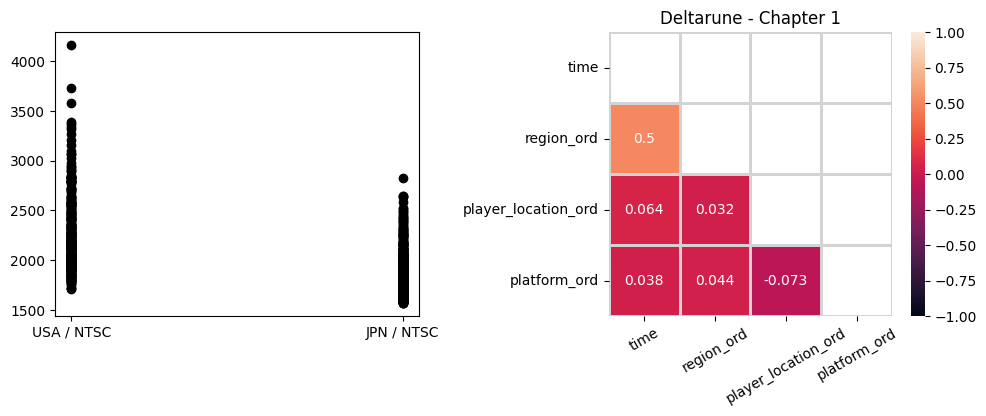

Pearsonova korelácia: 0.5016445239939415, ρ-hodnota: 2.8816105385815375e-41
JPN / NTSC, mean: 1905.26, min: 1567.9
USA / NTSC, mean: 2271.2, min: 1714.43


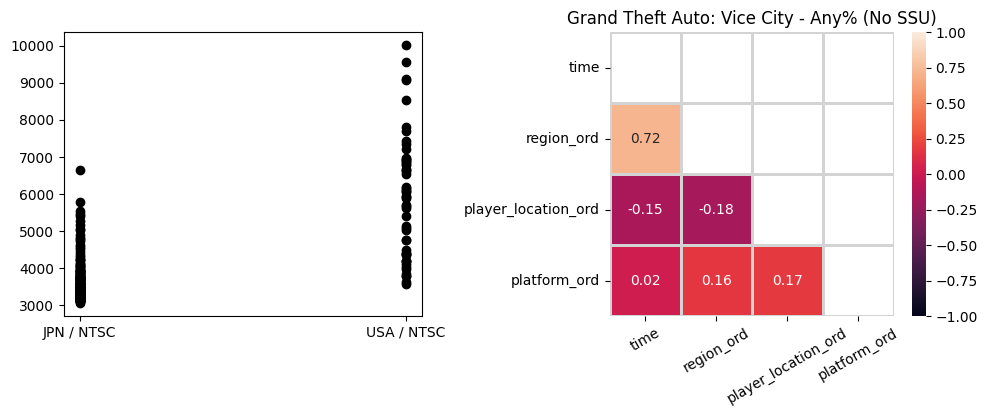

Pearsonova korelácia: 0.7178384473582381, ρ-hodnota: 7.099834661386441e-38
JPN / NTSC, mean: 3670.53, min: 3047.0
USA / NTSC, mean: 5908.69, min: 3574.0


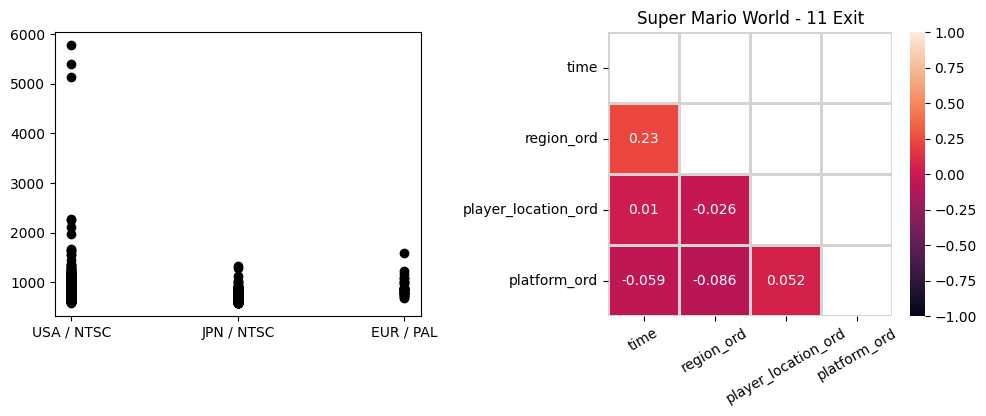

Pearsonova korelácia: 0.23303399407593298, ρ-hodnota: 7.55763589306145e-18
EUR / PAL, mean: 903.8, min: 691.15
JPN / NTSC, mean: 699.66, min: 582.98
USA / NTSC, mean: 827.9, min: 588.98


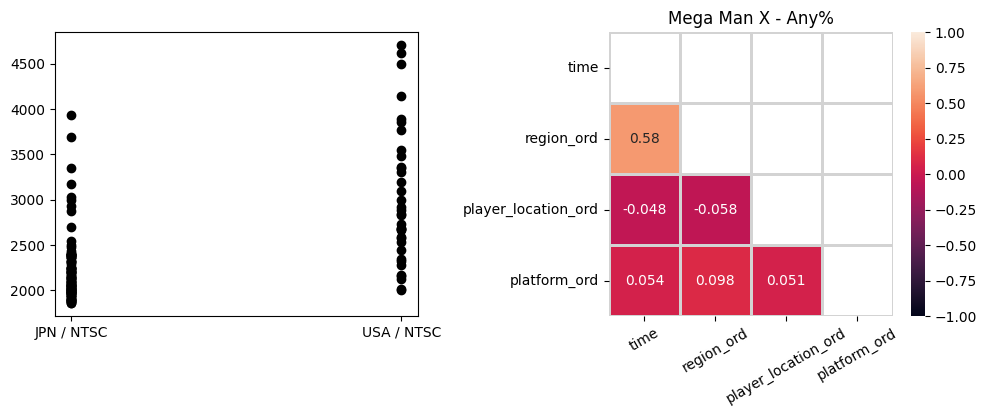

Pearsonova korelácia: 0.5782077800183599, ρ-hodnota: 2.0792096305269951e-13
JPN / NTSC, mean: 2224.29, min: 1860.0
USA / NTSC, mean: 3008.86, min: 2002.0


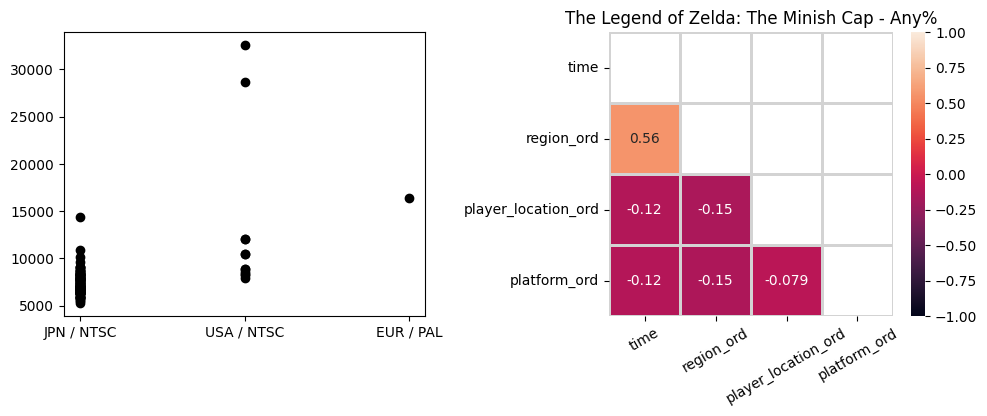

Pearsonova korelácia: 0.5597309854745339, ρ-hodnota: 1.3975231272987999e-11
EUR / PAL, mean: 16381.0, min: 16381.0
JPN / NTSC, mean: 7348.39, min: 5260.0
USA / NTSC, mean: 13099.75, min: 7913.0


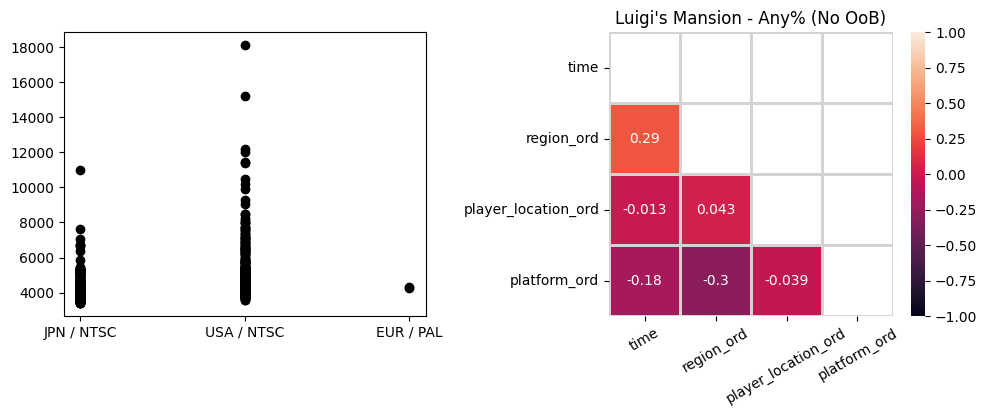

Pearsonova korelácia: 0.29301967419129027, ρ-hodnota: 2.8129884049764638e-11
EUR / PAL, mean: 4293.5, min: 4267.0
JPN / NTSC, mean: 4321.21, min: 3395.0
USA / NTSC, mean: 5248.52, min: 3585.0


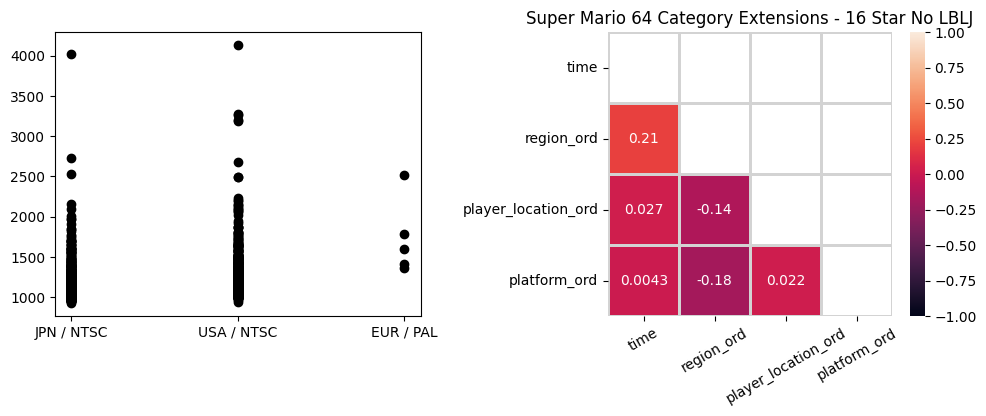

Pearsonova korelácia: 0.20930039336152154, ρ-hodnota: 4.767299654899182e-10
EUR / PAL, mean: 1737.0, min: 1368.0
JPN / NTSC, mean: 1203.35, min: 928.0
USA / NTSC, mean: 1325.25, min: 937.0


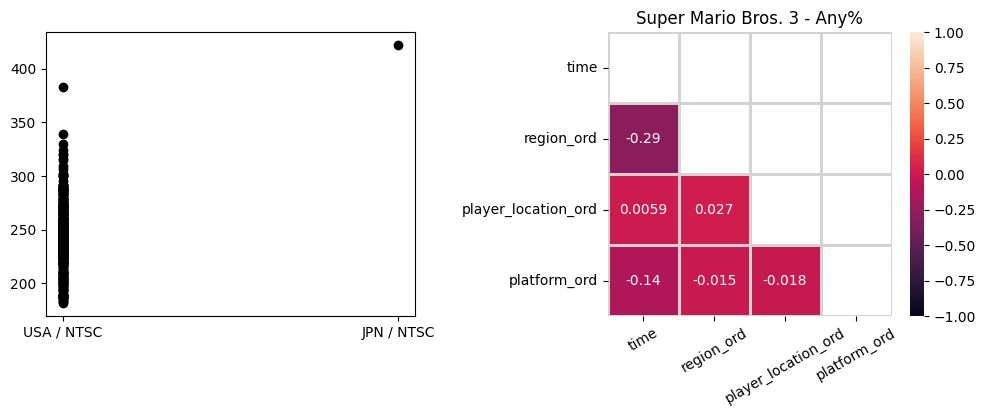

Pearsonova korelácia: -0.29124879905480827, ρ-hodnota: 4.962099305870422e-10
JPN / NTSC, mean: 422.0, min: 422.0
USA / NTSC, mean: 244.03, min: 181.7


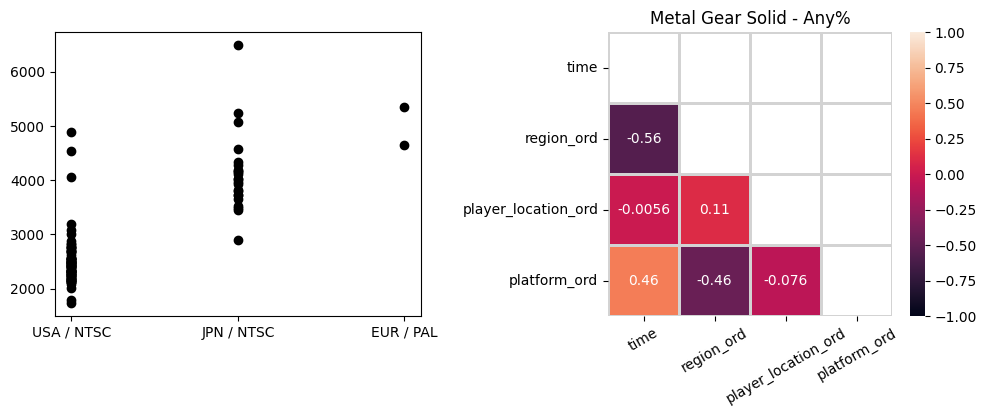

Pearsonova korelácia: -0.5608641532792744, ρ-hodnota: 5.932090412230359e-10
EUR / PAL, mean: 4999.5, min: 4648.0
JPN / NTSC, mean: 4113.91, min: 2894.0
USA / NTSC, mean: 2503.72, min: 1735.0


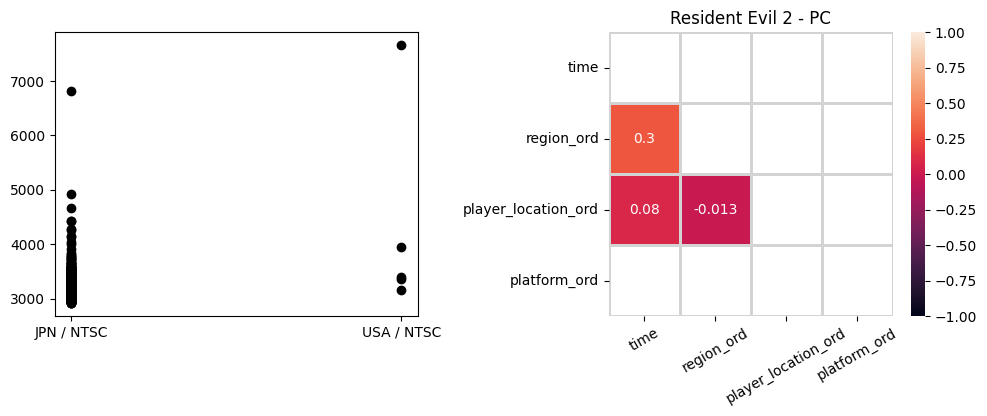

Pearsonova korelácia: 0.2953537409779992, ρ-hodnota: 1.1200039032415538e-09
JPN / NTSC, mean: 3264.45, min: 2916.0
USA / NTSC, mean: 4304.6, min: 3151.0


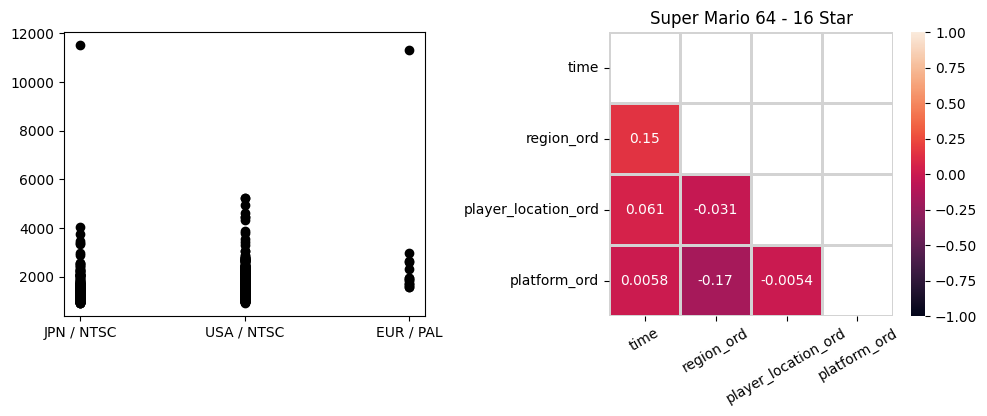

Pearsonova korelácia: 0.1460745402325608, ρ-hodnota: 5.860602358536225e-08
EUR / PAL, mean: 2700.64, min: 1574.0
JPN / NTSC, mean: 1399.49, min: 919.66
USA / NTSC, mean: 1522.18, min: 935.0


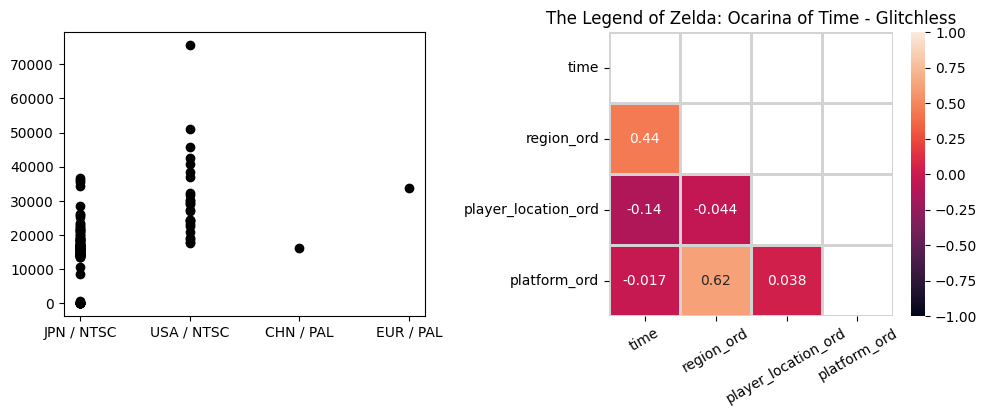

Pearsonova korelácia: 0.4418893695897708, ρ-hodnota: 1.1312701973655634e-07
CHN / PAL, mean: 16338.0, min: 16338.0
EUR / PAL, mean: 33867.0, min: 33867.0
JPN / NTSC, mean: 15174.26, min: 90.08
USA / NTSC, mean: 31313.0, min: 17810.0


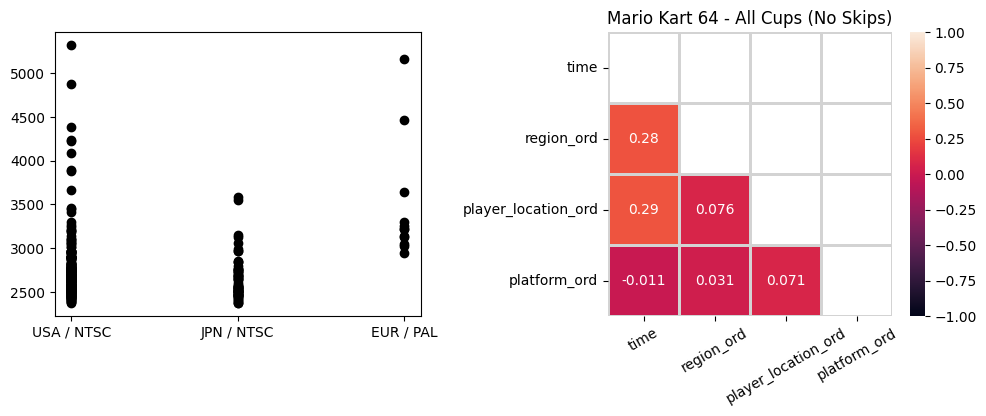

Pearsonova korelácia: 0.2771812247314409, ρ-hodnota: 7.42213355549522e-07
EUR / PAL, mean: 3461.42, min: 2946.0
JPN / NTSC, mean: 2647.88, min: 2372.0
USA / NTSC, mean: 2763.23, min: 2371.0


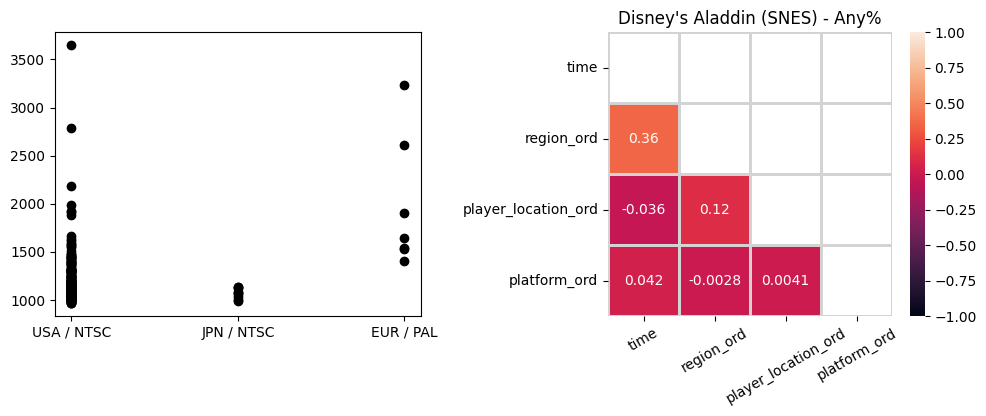

Pearsonova korelácia: 0.35544254837107364, ρ-hodnota: 1.1232148176955824e-06
EUR / PAL, mean: 1979.43, min: 1403.0
JPN / NTSC, mean: 1067.87, min: 982.82
USA / NTSC, mean: 1231.47, min: 965.84


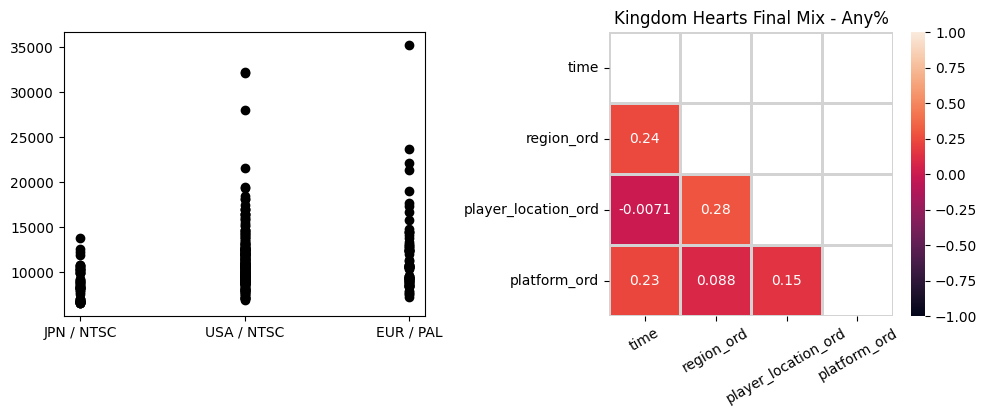

Pearsonova korelácia: 0.2396572733528977, ρ-hodnota: 4.525345966649665e-06
EUR / PAL, mean: 11742.57, min: 7189.0
JPN / NTSC, mean: 8685.75, min: 6521.0
USA / NTSC, mean: 11388.06, min: 6884.0


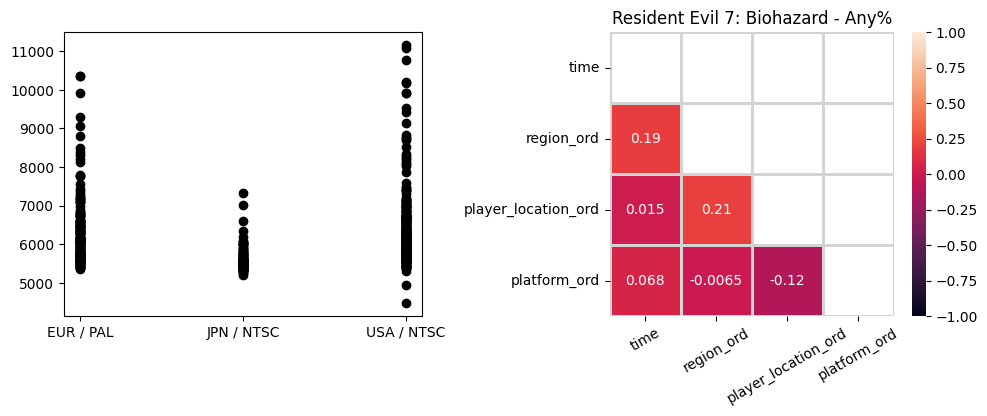

Pearsonova korelácia: 0.19218458702148575, ρ-hodnota: 1.2655061535813522e-05
EUR / PAL, mean: 6334.38, min: 5371.0
JPN / NTSC, mean: 5648.59, min: 5206.0
USA / NTSC, mean: 6425.08, min: 4475.0


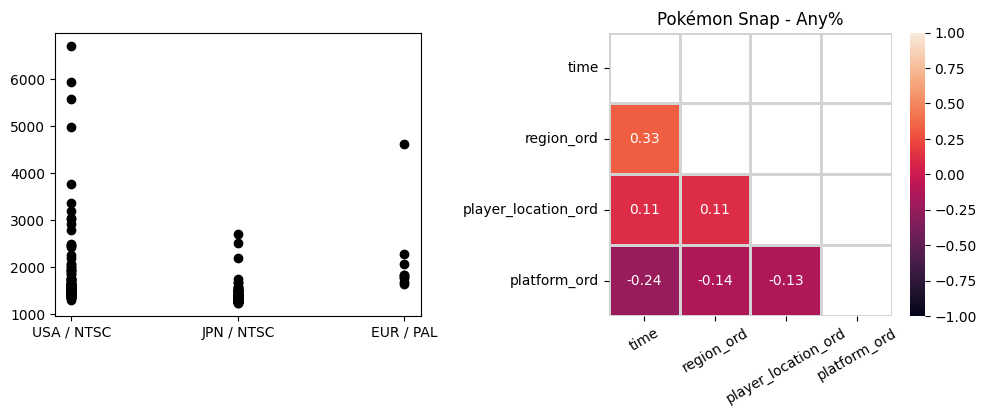

Pearsonova korelácia: 0.3256428831507864, ρ-hodnota: 1.3063596823191666e-05
EUR / PAL, mean: 2169.0, min: 1641.0
JPN / NTSC, mean: 1433.98, min: 1232.47
USA / NTSC, mean: 1939.64, min: 1301.0


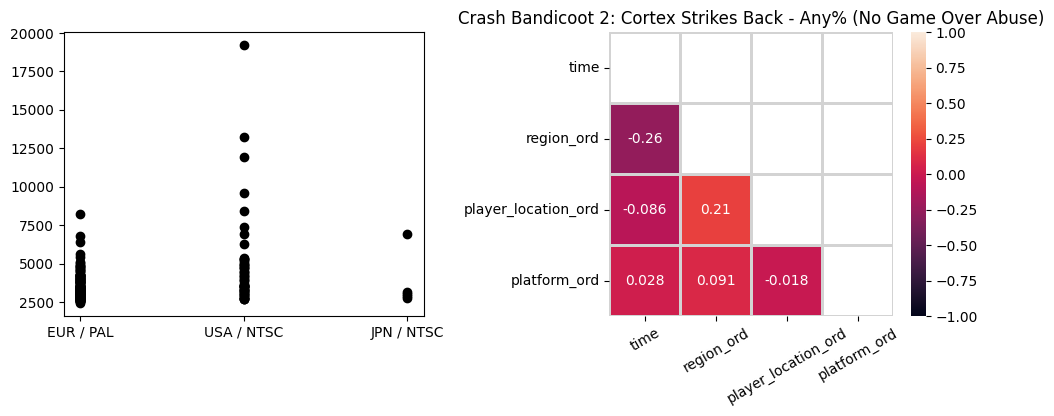

Pearsonova korelácia: -0.26083727613407104, ρ-hodnota: 0.00025805806825577557
EUR / PAL, mean: 3542.37, min: 2436.0
JPN / NTSC, mean: 3755.4, min: 2795.0
USA / NTSC, mean: 4821.42, min: 2687.0


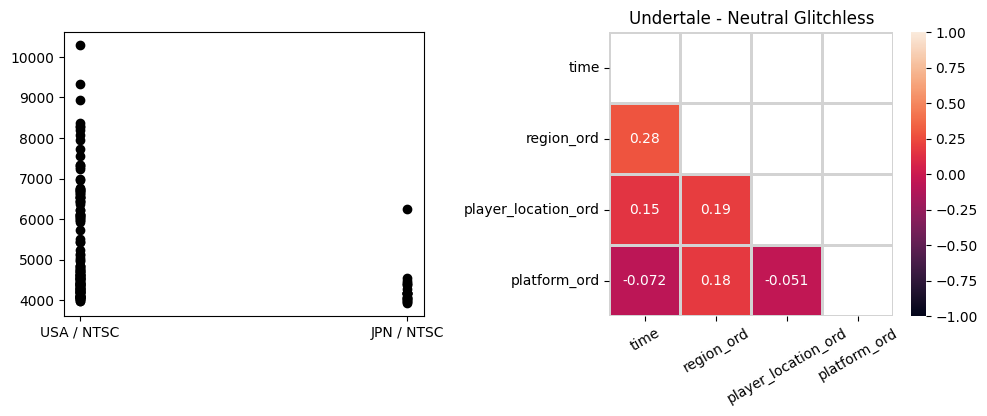

Pearsonova korelácia: 0.28255754764871527, ρ-hodnota: 0.0005252885424687554
JPN / NTSC, mean: 4281.55, min: 3924.0
USA / NTSC, mean: 5386.32, min: 3973.0


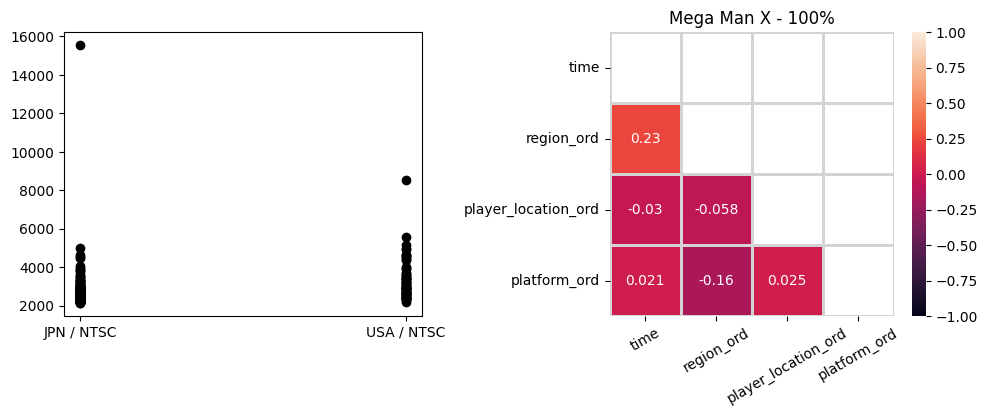

Pearsonova korelácia: 0.22885754906751254, ρ-hodnota: 0.0005727733724235353
JPN / NTSC, mean: 2745.58, min: 2134.0
USA / NTSC, mean: 3330.34, min: 2176.0


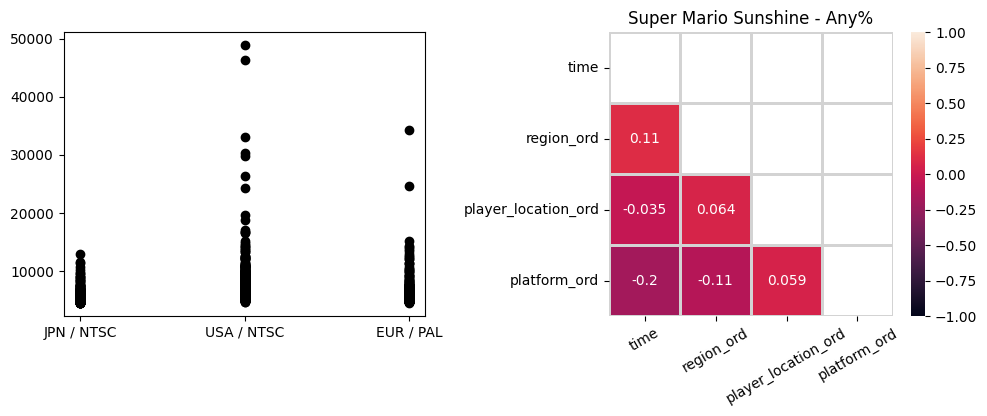

Pearsonova korelácia: 0.11238350356204649, ρ-hodnota: 0.000608152782483819
EUR / PAL, mean: 7036.69, min: 4541.0
JPN / NTSC, mean: 5825.51, min: 4453.0
USA / NTSC, mean: 7515.78, min: 4658.0


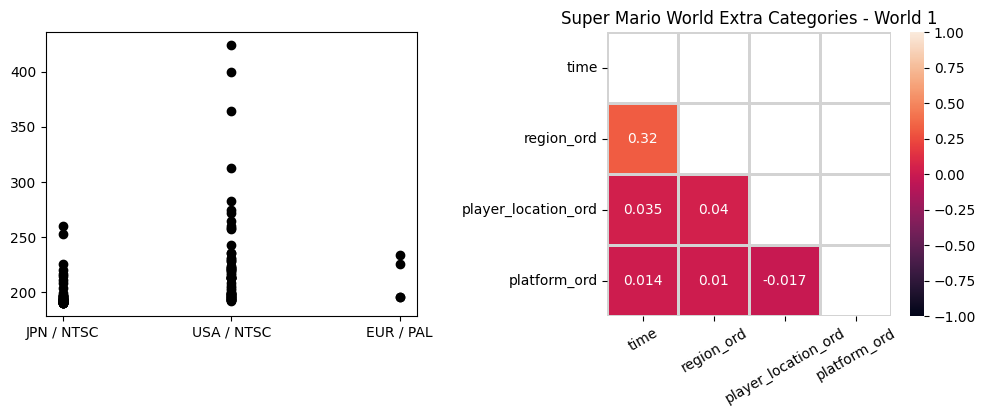

Pearsonova korelácia: 0.3183514461931913, ρ-hodnota: 0.0007004906251454567
EUR / PAL, mean: 213.03, min: 195.93
JPN / NTSC, mean: 198.94, min: 190.32
USA / NTSC, mean: 228.11, min: 192.38


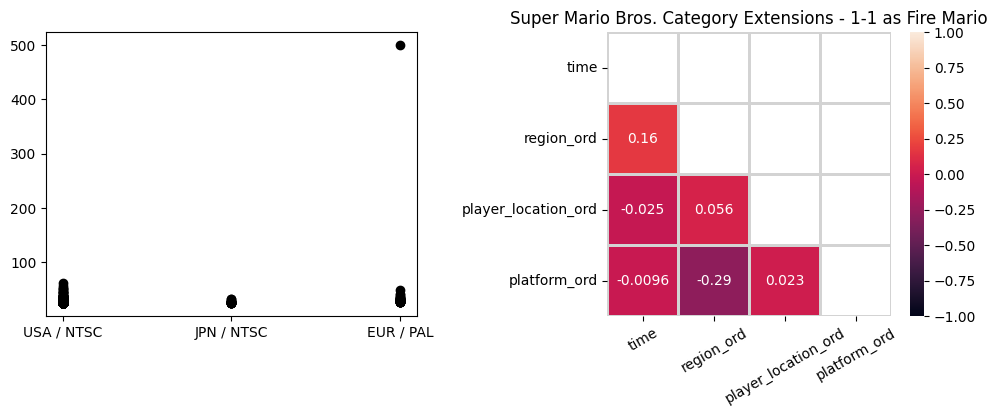

Pearsonova korelácia: 0.164103174489857, ρ-hodnota: 0.0007574033666756236
EUR / PAL, mean: 44.62, min: 26.0
JPN / NTSC, mean: 26.83, min: 24.84
USA / NTSC, mean: 27.66, min: 24.68


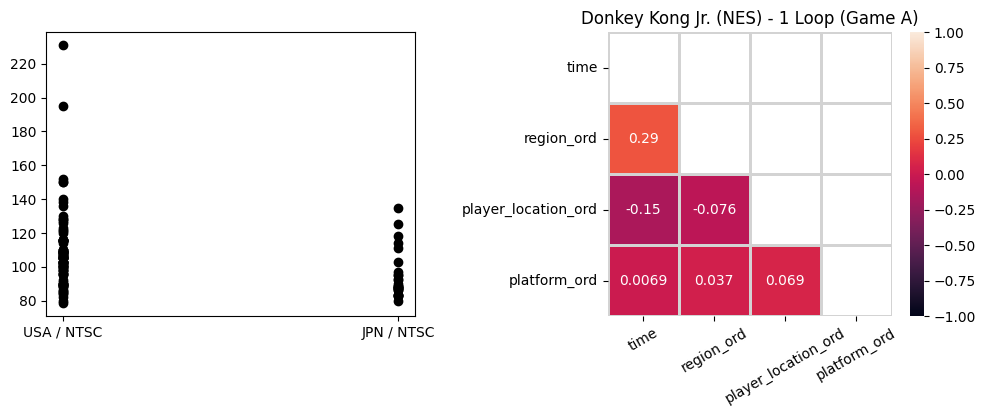

Pearsonova korelácia: 0.28697975024796285, ρ-hodnota: 0.0015541749859550274
JPN / NTSC, mean: 94.2, min: 79.7
USA / NTSC, mean: 108.63, min: 78.5


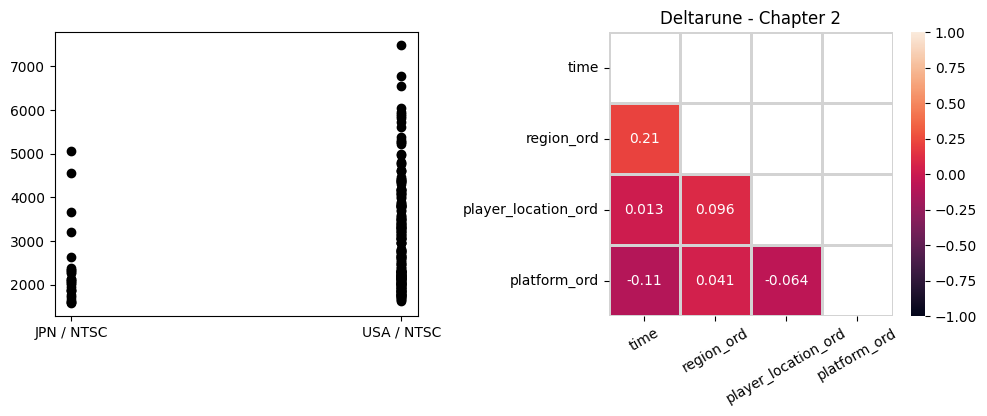

Pearsonova korelácia: 0.21167970688810625, ρ-hodnota: 0.0017136329020954791
JPN / NTSC, mean: 2336.19, min: 1579.0
USA / NTSC, mean: 3109.61, min: 1618.0


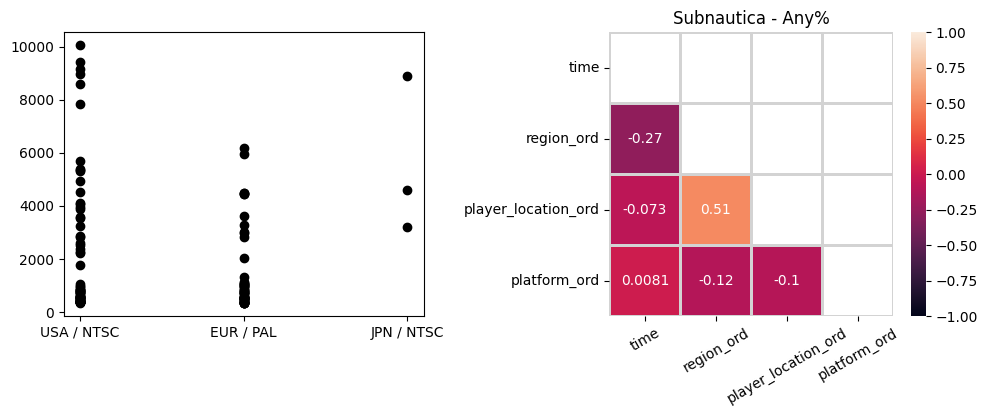

Pearsonova korelácia: -0.2747469635172266, ρ-hodnota: 0.00201425016010349
EUR / PAL, mean: 1397.96, min: 335.0
JPN / NTSC, mean: 5563.67, min: 3216.0
USA / NTSC, mean: 2300.7, min: 333.0


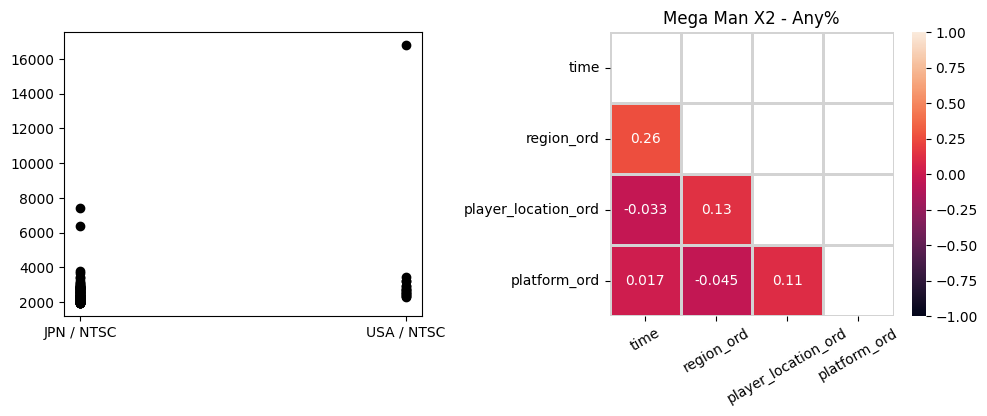

Pearsonova korelácia: 0.25905165304075467, ρ-hodnota: 0.002154698836826306
JPN / NTSC, mean: 2465.33, min: 1949.0
USA / NTSC, mean: 3556.65, min: 2297.0


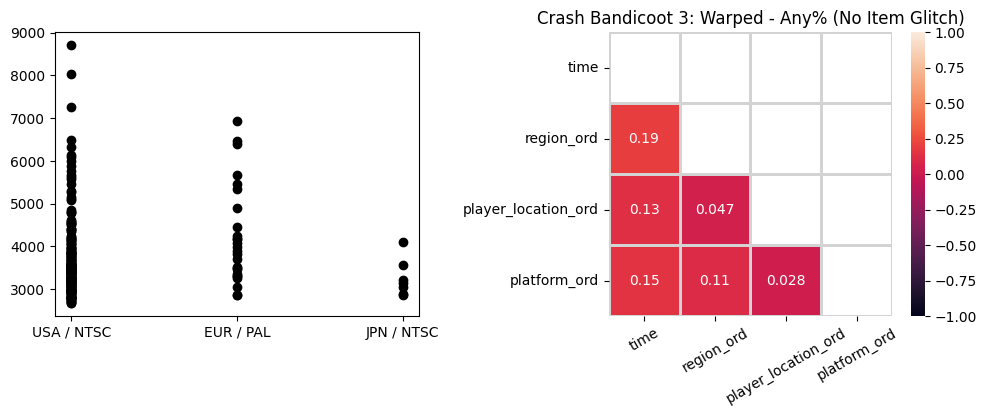

Pearsonova korelácia: 0.19091819722168374, ρ-hodnota: 0.0031695323031890707
EUR / PAL, mean: 4240.08, min: 2870.0
JPN / NTSC, mean: 3259.43, min: 2871.0
USA / NTSC, mean: 3721.69, min: 2674.0


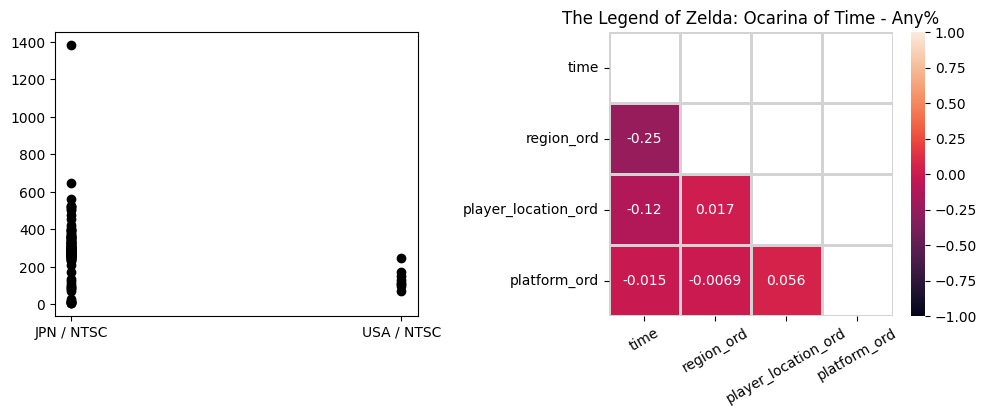

Pearsonova korelácia: -0.2453244496537439, ρ-hodnota: 0.0032542186330295846
JPN / NTSC, mean: 291.67, min: 6.83
USA / NTSC, mean: 136.19, min: 71.0


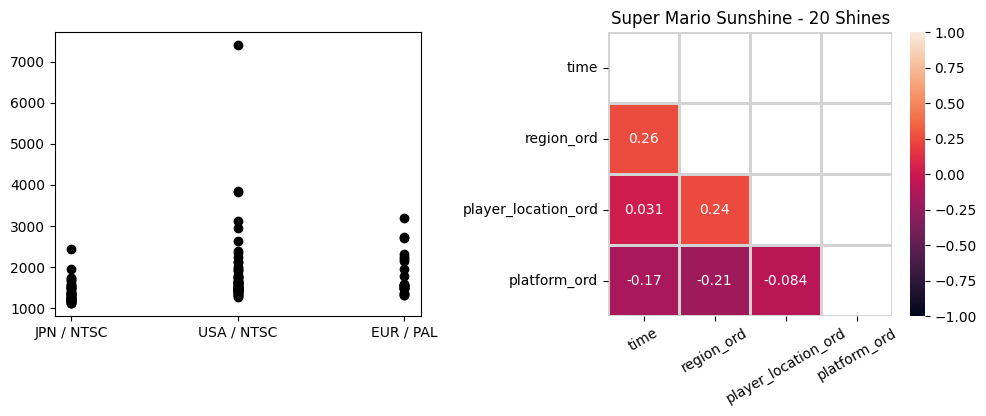

Pearsonova korelácia: 0.25773387639845896, ρ-hodnota: 0.0035727183556502175
EUR / PAL, mean: 1806.25, min: 1317.0
JPN / NTSC, mean: 1375.67, min: 1118.0
USA / NTSC, mean: 1863.19, min: 1259.0


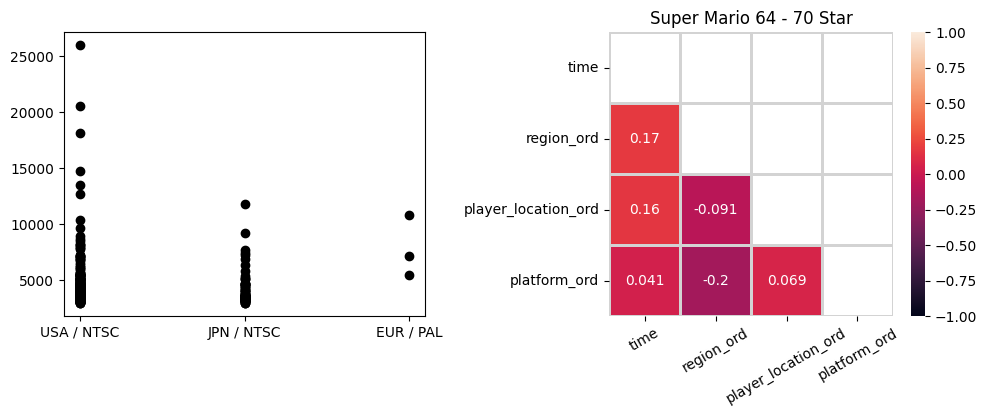

Pearsonova korelácia: 0.1733740501426889, ρ-hodnota: 0.0037985744243711496
EUR / PAL, mean: 7779.67, min: 5434.0
JPN / NTSC, mean: 4104.26, min: 2918.0
USA / NTSC, mean: 4912.05, min: 2925.0


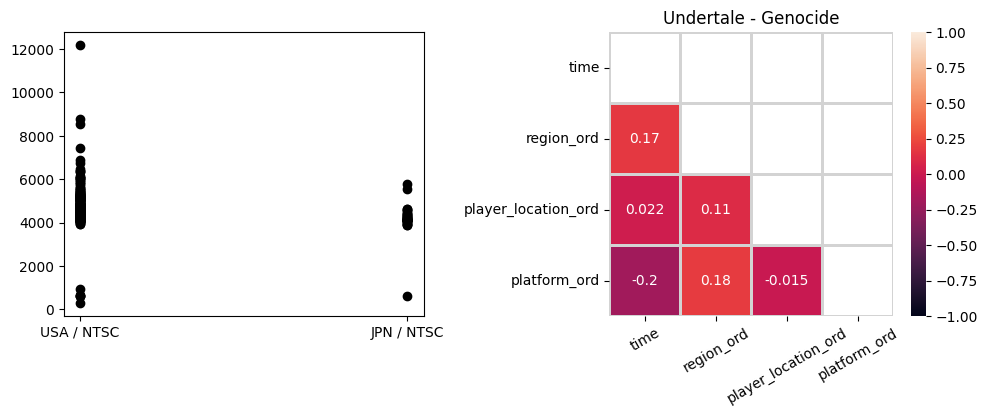

Pearsonova korelácia: 0.16571649382604295, ρ-hodnota: 0.005035726248715868
JPN / NTSC, mean: 4191.42, min: 620.0
USA / NTSC, mean: 4697.18, min: 293.0


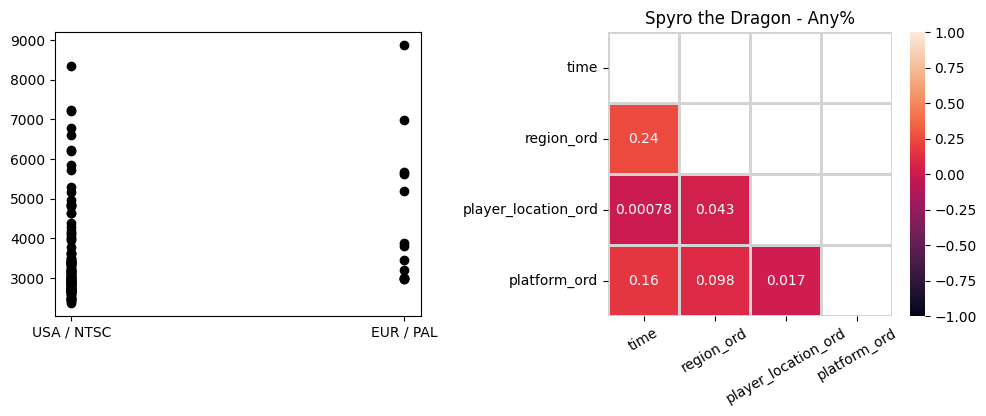

Pearsonova korelácia: 0.24429734834683062, ρ-hodnota: 0.005093053926344367
EUR / PAL, mean: 4506.54, min: 2968.0
USA / NTSC, mean: 3476.92, min: 2363.0


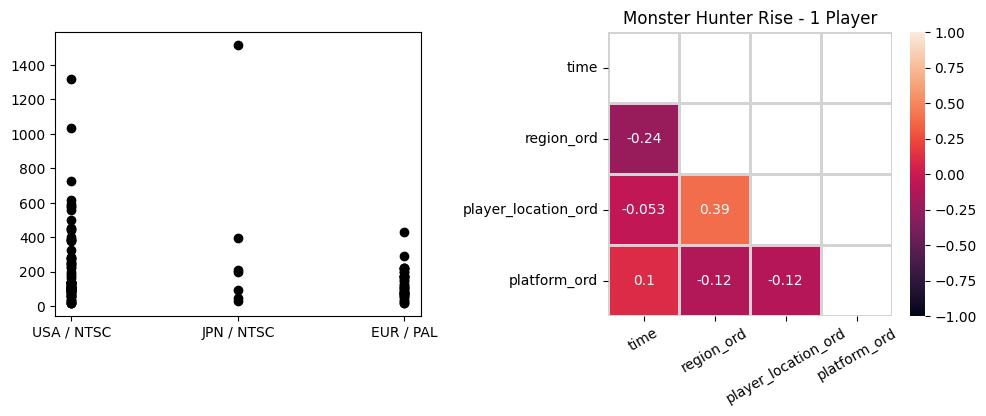

Pearsonova korelácia: -0.23627026154167535, ρ-hodnota: 0.007984808210967946
EUR / PAL, mean: 131.56, min: 18.03
JPN / NTSC, mean: 355.64, min: 31.19
USA / NTSC, mean: 218.98, min: 17.65


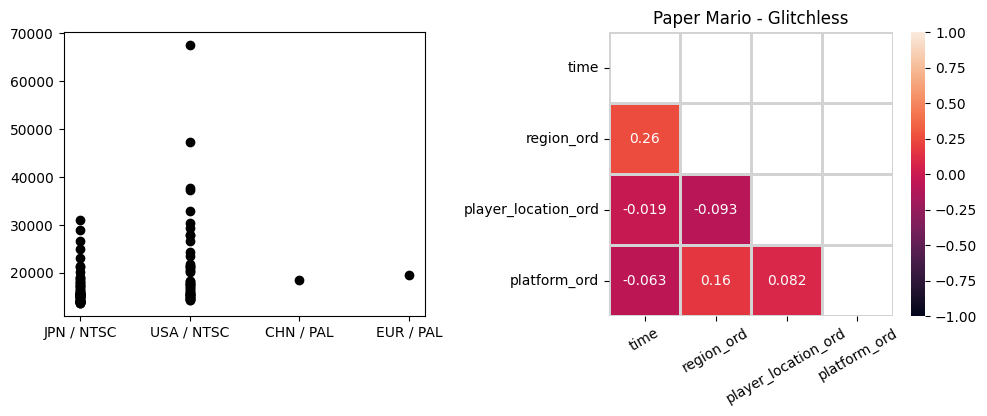

Pearsonova korelácia: 0.2572494701306459, ρ-hodnota: 0.00838262473572465
CHN / PAL, mean: 18446.0, min: 18446.0
EUR / PAL, mean: 19463.0, min: 19463.0
JPN / NTSC, mean: 16814.95, min: 13670.0
USA / NTSC, mean: 21858.05, min: 14221.0


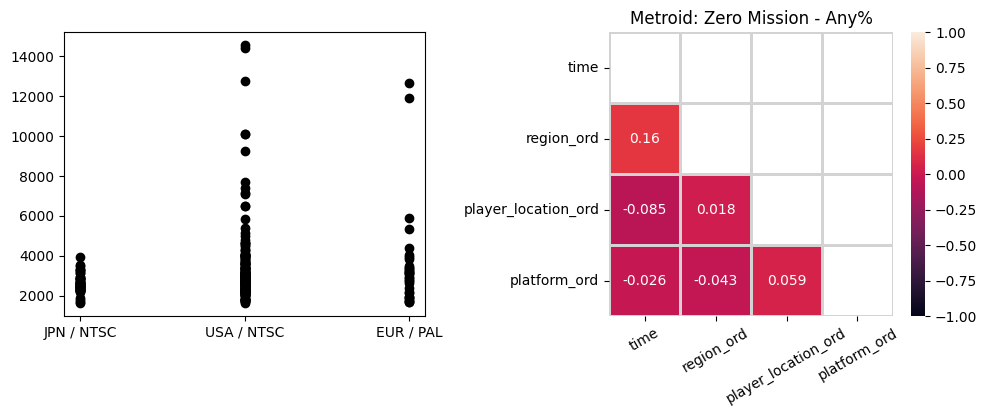

Pearsonova korelácia: 0.16008215241078375, ρ-hodnota: 0.009583094068160552
EUR / PAL, mean: 3575.34, min: 1668.0
JPN / NTSC, mean: 2609.38, min: 1620.0
USA / NTSC, mean: 3389.15, min: 1633.0



	Počet najlepších priemerov pre región:
{'EUR / PAL': 4, 'JPN / NTSC': 28, 'USA / NTSC': 4}
	Počet najlepších časov pre región:
{'EUR / PAL': 1, 'JPN / NTSC': 23, 'USA / NTSC': 12}


In [12]:
min_dict = {}
mean_dict = {}

for df in significant_corr_dfs:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    plt.title("{} - {}".format(df['game'].values[0], df['category'].values[0]))
    axes[0].plot(df["region"], df["time"], 'o', color='black')
    corr_df = df[["time", "region_ord", "player_location_ord", "platform_ord"]]
    corr = corr_df.corr()
    
    mask = np.triu(np.ones_like(corr_df.corr(), dtype=np.bool))
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, square=True, linecolor="lightgray", linewidths=1, ax=axes[1])
    plt.xticks(rotation=30)
    fig.tight_layout()
    plt.show()
    
    corr, p = pearsonr(df["time"], df["region_ord"])
    print("Pearsonova korelácia: {}, ρ-hodnota: {}".format(corr, p))
    regions = df["region"].unique().tolist()
    regions.sort()
    
    min_mean = 1000000000
    min_min = 1000000000
    mean_reg = regions[0]
    min_reg = regions[0]
    for region in regions:
        mean = round(df.loc[df["region"] == region]["time"].mean(), 2)
        if mean < min_mean:
            min_mean = mean
            mean_reg = region
        mini = round(df.loc[df["region"] == region]["time"].min(), 2)
        if mini < min_min:
            min_min = mini
            min_reg = region
        print("{}, mean: {}, min: {}".format(region, mean, mini))
    mean_dict[mean_reg] = mean_dict.setdefault(mean_reg, 0) + 1
    min_dict[min_reg] = min_dict.setdefault(min_reg, 0) + 1
print("\n\n")
print("\tPočet najlepších priemerov pre región:")
pprint(mean_dict)
print("\tPočet najlepších časov pre región:")
pprint(min_dict)

28 z 36 hier s japonskou lokalizíciou malo najnižší priemerný čas, 23 z nich najmenší minimálny čas, a vo veľkom počte prípadov mali rozloženie časov blízko seba, teda boli konzistentnejšie nižšie ako lokalizácie iných regiónv. Z tohto vyplýva, že vo veľa prípadoch fakt, že hra je v japonskej lokalizácií pomáha pri získaní lepšieho času. V niektorých prípadoch je naopak lepší iný región, napríklad pre Metal Gear Solid (Any%) je USA verzia oveľa rýchlejšia. Dôvody na to, prečo to takto je však z dostupných údajov nemožno vyvodiť a bolo by treba analyzovať jednotlivé hry podrobnejšie. Z dát ale vieme vyvodiť, že v prípadoch, keď lokalizácia má dopad na herné časy, je japonská lokalizácia pre tú istú hru a kategóriu porovnatelne rýchlejšia ako jej iné lokalizácie.